In [ ]:
import torch
import pyro
import numpy as np
import pyro.distributions as dist

In [77]:
def synthetic_dataset_pyro(
    n: int = 2000,
    beta: float = 2.0,
    num_proxies: int = 10,
    shuffle_pct: float = 0.0,
    prior_type: str = "gaussian",
    sigma_x: float = 1.0,
    sigma_y: float = 1.0,
    seed: int | None = None,
):
    """
    Pyro-based generator equivalent to the NumPy version you posted. Returns:
      x: [n, num_proxies]   (proxy covariates)
      t: [n]               (binary treatment)
      y: [n]               (continuous outcome)
      z: [n]               (latent confounder, continuous or bimodal)
      ite: [n]             (true individual treatment effect = 1 + 0.5*z)
    """

    # -------------- 1. Set seed for reproducibility -------------------
    if seed is not None:
        pyro.set_rng_seed(seed)
        torch.manual_seed(seed)

    # -------------- 2. Sample latent confounder z ---------------------
    if prior_type == "gaussian":
        # z ~ Normal(0, 1)
        z = dist.Normal(0.0, 1.0).sample([n])
    elif prior_type == "bimodal":
        # mixture: component ~ Bernoulli(0.5), then Normal(center, 1)
        comp = dist.Bernoulli(0.5).sample([n])  # 0 or 1
        # define centers: 1 → +2, 0 → -2
        centers = torch.where(comp == 1, torch.full([n], 2.0), torch.full([n], -2.0))
        z = centers + dist.Normal(0.0, 1.0).sample([n])
    else:
        raise ValueError("prior_type must be 'gaussian' or 'bimodal'")

    # -------------- 3. Generate proxy covariates x -------------------
    # a_j ~ Uniform(0.5, 1.5) for each proxy dimension j
    a = dist.Uniform(-1.5, 1.5).sample([num_proxies])           # shape: [num_proxies]
    # noise ε_ij ~ Normal(0, sigma_x)
    eps = dist.Normal(0.0, sigma_x).sample([n, num_proxies])   # shape: [n, num_proxies]
    # x_ij = tanh(z_i) * a_j + ε_ij
    x = torch.tanh(z).unsqueeze(1) * a.unsqueeze(0) + eps      # shape: [n, num_proxies]

    # Optionally shuffle a fraction of proxy columns to break their link to z
    if shuffle_pct > 0.0:
        k = int(num_proxies * shuffle_pct)
        cols_to_shuffle = torch.randperm(num_proxies)[:k]
        for c in cols_to_shuffle:
            x[:, c] = x[torch.randperm(n), c]

    # -------------- 4. Sample treatment assignment t ------------------
    # p(t=1 | z) = sigmoid(beta * z)
    p_t = torch.sigmoid(beta * z)
    t = dist.Bernoulli(probs=p_t).sample()                     # shape: [n]

    # -------------- 5. Generate continuous outcome y -----------------
    # g(z) = sin(z) + 0.5 * z
    g = torch.sin(z) + 0.5 * z
    # τ(z) = 1 + 0.5 * z   (true ITE)
    tau = 1.0 + 0.5 * z
    # y_mean_i = g(z_i) + τ(z_i)*t_i
    y_mean = g + tau * t
    # add noise: y_i ~ Normal(y_mean_i, sigma_y)
    y = dist.Normal(y_mean, sigma_y).sample()                   # shape: [n]

    # -------------- 6. Return everything as a dict --------------------
    return {
        "x": x,                  # [n, num_proxies]
        "t": t,                  # [n]
        "y": y,                  # [n]
        "z": z,                  # [n]
        "ite": tau               # [n]  (since ITE = 1 + 0.5*z exactly)
    }


In [79]:
import matplotlib.pyplot as plt

# Plot the distribution of z
def plot_distribution(data, variable_name="z"):
    plt.figure(figsize=(8, 6))
    plt.hist(data[variable_name].numpy(), bins=30, density=True, alpha=0.7)
    plt.title(f"Distribution of {variable_name}", fontsize=16)
    plt.xlabel(variable_name, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.grid(alpha=0.3)
    plt.show()

def plot_z_with_ite(data):
    plt.figure(figsize=(8, 6))
    plt.scatter(data['z'].numpy(), data['ite'].numpy(), alpha=0.5)
    plt.title("ITE vs Latent Confounder z", fontsize=16)
    plt.xlabel("z", fontsize=14)
    plt.ylabel("ITE", fontsize=14)
    plt.grid(alpha=0.3)
    plt.show()

In [74]:
data = synthetic_dataset_pyro(n=1000, beta=1.0, num_proxies=5, shuffle_pct=0.2, seed=42, prior_type="gaussian")

Text(0.5, 1.0, 'Outcome y vs. latent z (colored by treatment)')

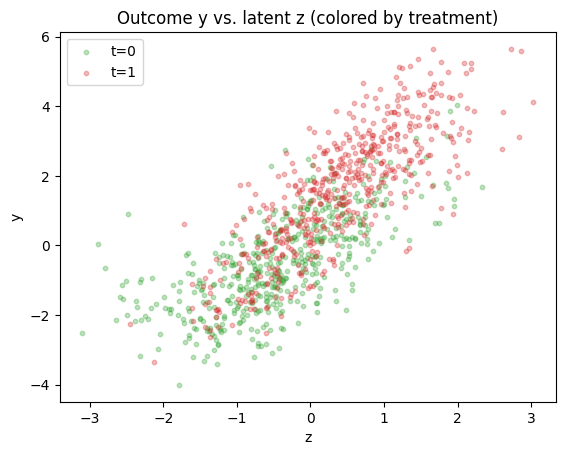

In [80]:

idx0 = (data['t'] == 0)
idx1 = (data['t'] == 1)
plt.scatter(data['z'][idx0], data['y'][idx0], s=10, alpha=0.3, label="t=0", color="C2")
plt.scatter(data['z'][idx1], data['y'][idx1], s=10, alpha=0.3, label="t=1", color="C3")
plt.xlabel("z")
plt.ylabel("y")
plt.legend()
plt.title("Outcome y vs. latent z (colored by treatment)")


Text(0.5, 1.0, 'Outcome y vs. x (colored by treatment)')

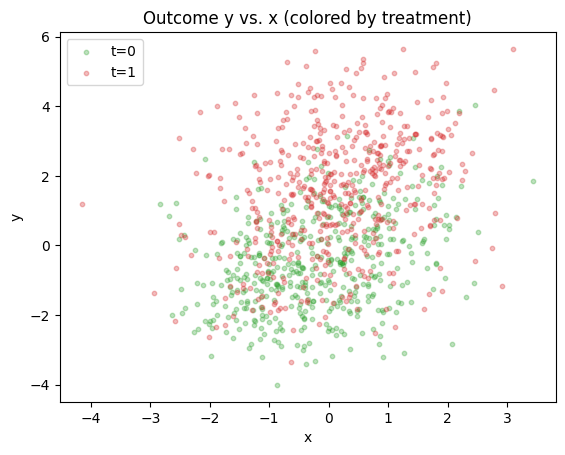

In [82]:

plt.scatter(data['x'][idx0, 0], data['y'][idx0], s=10, alpha=0.3, label="t=0", color="C2")
plt.scatter(data['x'][idx1, 0], data['y'][idx1], s=10, alpha=0.3, label="t=1", color="C3")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Outcome y vs. x (colored by treatment)")


/tmp/ipykernel_117422/4135004867.py:10: RuntimeWarning: Mean of empty slice.
  means_t1.append(y[(mask_bin) & (t==1)].mean())
/home/giovanni/sci-env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_117422/4135004867.py:9: RuntimeWarning: Mean of empty slice.
  means_t0.append(y[(mask_bin) & (t==0)].mean())


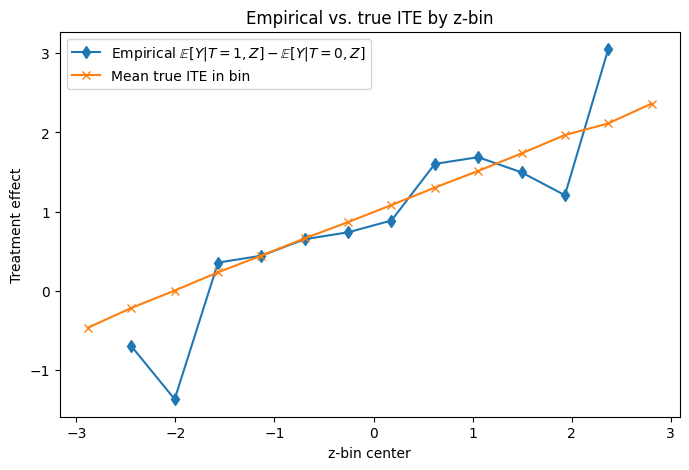

In [48]:
bins = np.linspace(z.min(), z.max(), 15)
means_t0 = []
means_t1 = []
centers = 0.5 * (bins[:-1] + bins[1:])

for i in range(len(bins)-1):
    mask_bin = (z >= bins[i]) & (z < bins[i+1])
    if mask_bin.sum() > 0:
        means_t0.append(y[(mask_bin) & (t==0)].mean())
        means_t1.append(y[(mask_bin) & (t==1)].mean())
    else:
        means_t0.append(np.nan)
        means_t1.append(np.nan)

# Plot the difference between means_t1 and means_t0
diff = np.array(means_t1) - np.array(means_t0)
plt.figure(figsize=(8, 5))
plt.plot(centers, diff, marker="d", label="Empirical $\\mathbb{E}[Y|T=1,Z]-\\mathbb{E}[Y|T=0,Z]$")
# Compute mean ITE in each z-bin for comparison
ite = data['ite'].numpy()
mean_ite = []
for i in range(len(bins)-1):
    mask_bin = (z >= bins[i]) & (z < bins[i+1])
    if mask_bin.sum() > 0:
        mean_ite.append(ite[mask_bin].mean())
    else:
        mean_ite.append(np.nan)
plt.plot(centers, mean_ite, marker="x", label="Mean true ITE in bin")
plt.xlabel("z‐bin center")
plt.ylabel("Treatment effect")
plt.legend()
plt.title("Empirical vs. true ITE by z-bin")
plt.show()


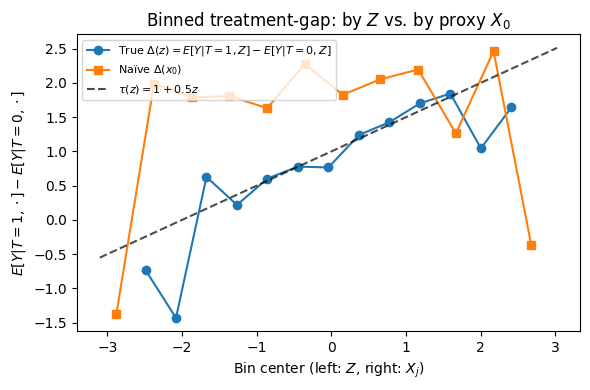

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def binned_diff(var, t, y, num_bins=15):
    """
    For a scalar array 'var' (shape [n]), compute
      E[Y | T=1, var in bin] - E[Y | T=0, var in bin]
    across num_bins equal‐width bins between var.min() and var.max().
    Returns: (bin_centers, diffs)
    """
    bins = np.linspace(var.min(), var.max(), num_bins + 1)
    centers = 0.5 * (bins[:-1] + bins[1:])
    diffs = []

    for i in range(num_bins):
        mask = (var >= bins[i]) & (var < bins[i+1])
        if mask.sum() == 0:
            diffs.append(np.nan)
            continue

        y_t1 = y[mask & (t == 1)]
        y_t0 = y[mask & (t == 0)]
        if (y_t1.size == 0) or (y_t0.size == 0):
            diffs.append(np.nan)
        else:
            diffs.append(y_t1.mean() - y_t0.mean())

    return centers, np.array(diffs)


# 1) Binning by Z (ground truth)
z_centers, delta_z = binned_diff(z, t, y, num_bins=15)

# 2) Binning by a chosen proxy X_j (e.g., j=0)
j = 0
xj_centers, delta_xj = binned_diff(x[:, j], t, y, num_bins=15)


# 3) Plot both on the same figure for comparison
plt.figure(figsize=(6,4))
plt.plot(z_centers, delta_z, '-o', label=r"True $\Delta(z)=E[Y|T{=}1,Z]-E[Y|T{=}0,Z]$")
plt.plot(xj_centers, delta_xj, '-s', label=fr"Naïve $\Delta(x_{{{j}}})$")

# Overlay the analytic line tau(z) = 1 + 0.5 z for reference
z_line = np.linspace(z.min(), z.max(), 200)
plt.plot(z_line, 1 + 0.5 * z_line, 'k--', alpha=0.7, label=r"$\tau(z)=1+0.5z$")

plt.xlabel(r"Bin center (left: $Z$, right: $X_j$)")
plt.ylabel(r"$E[Y|T=1,\cdot] - E[Y|T=0,\cdot]$")
plt.legend(loc="upper left", fontsize=8)
plt.title(f"Binned treatment‐gap: by $Z$ vs. by proxy $X_{{{j}}}$")
plt.tight_layout()
plt.show()


# proxy extimated ite

A trivial idea is to assume a linear relationship: $Y_i=\alpha+\beta\cdot X_i + \gamma T$ to estimate the the ATE